# Imports

In [52]:
from transformers import BertTokenizerFast, BertForTokenClassification, get_scheduler, Trainer, TrainingArguments, AdamW

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW

from datasets import load_dataset
from datasets import Dataset
import csv

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import os

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score



# Funções Auxiliares

In [53]:
# Função para carregar os dados
def load_data(filepath):
    sentences = []
    labels = []
    with open(filepath, "r", encoding="utf-8") as file:
        for line in file:
            tokens, tags = [], []
            for pair in line.strip().split():
                word, tag = pair.rsplit("_", 1)
                tokens.append(word)
                tags.append(tag)
            sentences.append(tokens)
            labels.append(tags)
    return sentences, labels

In [54]:
def preprocess(sentences, tags, tokenizer, tag_encoder):
    input_ids, attention_masks, labels = [], [], []

    for sentence, tag_seq in zip(sentences, tags):
        # Tokenizar as frases
        encoding = tokenizer(
            sentence,
            is_split_into_words=True,
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt"
        )

        # Ajustar os rótulos para sub-tokens
        word_ids = encoding.word_ids()
        label_ids = []
        previous_word_idx = None

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Ignorar sub-tokens fora da sequência
            elif word_idx != previous_word_idx:
                label_ids.append(tag_encoder.transform([tag_seq[word_idx]])[0])
            else:
                label_ids.append(-100)  # Ignorar sub-tokens adicionais

            previous_word_idx = word_idx

        input_ids.append(encoding["input_ids"])
        attention_masks.append(encoding["attention_mask"])
        labels.append(torch.tensor(label_ids))

    return torch.cat(input_ids), torch.cat(attention_masks), torch.stack(labels)

In [55]:
def create_dataloader(inputs, masks, labels, batch_size=16):
    data = TensorDataset(inputs, masks, labels)
    return DataLoader(data, batch_size=batch_size)

In [56]:
def compute_metrics(eval_pred, tag_encoder):
    logits, labels = eval_pred
    predictions = torch.argmax(logits, dim=-1).flatten().cpu().numpy()
    labels = labels.flatten().cpu().numpy()

    # Ignorar sub-tokens, onde a label é -100
    mask = labels != -100
    predictions = predictions[mask]
    labels = labels[mask]

    accuracy = accuracy_score(labels, predictions)

    #print a palavra o predict e o label
    for i in range(len(labels)):
        print(f'{tag_encoder.inverse_transform([predictions[i]])} - {tag_encoder.inverse_transform([labels[i]])}')
    # Adicionar outras métricas, se necessário
    return {"accuracy": accuracy}

In [57]:
def create_hf_dataset(inputs, masks, labels):
    data = {
        "input_ids": inputs.tolist(),
        "attention_mask": masks.tolist(),
        "labels": labels.tolist(),
    }
    return Dataset.from_dict(data)

In [58]:
def save_model(model, tokenizer, save_directory):
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    model.save_pretrained(save_directory)
    tokenizer.save_pretrained(save_directory)
    print(f"Modelo salvo em: {save_directory}")

# Tokenização com BERT

In [59]:
# Configurações iniciais
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Caminhos para os arquivos de dados
train_file = "./corpus/macmorpho-train.txt"
val_file = "./corpus/macmorpho-dev.txt"
test_file = "./corpus/macmorpho-test.txt"

data_files = {
    "train": train_file,
    "validation": val_file,
    "test": test_file,
}

# Carregar os dados
tokens_train, tags_train = load_data(train_file)
tokens_val, tags_val = load_data(val_file)
tokens_test, tags_test = load_data(test_file)

# Inicializar o tokenizer e o modelo pré-treinado
tokenizer = BertTokenizerFast.from_pretrained("neuralmind/bert-base-portuguese-cased")
num_classes = len(set(tag for sent_tags in tags_train for tag in sent_tags))

model = BertForTokenClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=num_classes
).to(device)

# Label Encoder para as tags
tag_encoder = LabelEncoder()
tag_encoder.fit([tag for sent_tags in tags_train for tag in sent_tags])

# Pré-processar os dados
train_inputs, train_masks, train_labels = preprocess(tokens_train, tags_train, tokenizer, tag_encoder)
val_inputs, val_masks, val_labels = preprocess(tokens_val, tags_val, tokenizer, tag_encoder)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Treinamento e Avaliação

In [60]:
PATH = "./training_output"

# Criar os DataLoaders
train_dataloader = create_dataloader(train_inputs, train_masks, train_labels) #usar para treinar
test_dataloader = create_dataloader(val_inputs, val_masks, val_labels) #usar para testar
val_dataloader = create_dataloader(val_inputs, val_masks, val_labels) #usar para validar

# Definir o otimizador
optimizer = AdamW(model.parameters(), lr=5e-5)
unique_labels = tag_encoder.classes_

# Supondo que os arquivos estejam no formato linha por linha (ajuste o formato, se necessário)
datasets = load_dataset("text", data_files=data_files)

# Divisão dos datasets
# train_dataset = datasets["train"]
# test_dataset = datasets["test"]
# val_dataset = datasets["validation"]

# Criar datasets no formato esperado
train_dataset = create_hf_dataset(train_inputs, train_masks, train_labels)
train_dataset = train_dataset.select(range(10000))  # Usar apenas 10.000 exemplos

test_dataset = create_hf_dataset(val_inputs, val_masks, val_labels)
val_dataset = create_hf_dataset(val_inputs, val_masks, val_labels)


In [61]:
training_args = TrainingArguments(
    load_best_model_at_end=True,
    output_dir=PATH,
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=300,
    save_steps=300,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    learning_rate=5e-5,
    weight_decay=0.01,
    num_train_epochs=1,
    logging_dir=f"{PATH}/log",
    save_total_limit=2,
    logging_steps=10,
    fp16=True,
)

# Limpar cache da GPU
torch.cuda.empty_cache()

# Criar o Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,   # Dataset de treinamento no formato esperado
    eval_dataset=test_dataset,     # Dataset de test no formato esperado
    optimizers=(optimizer, None),  # Passando o otimizador
    compute_metrics=lambda eval_pred: compute_metrics(eval_pred, unique_labels),
)

# Iniciar o treinamento
trainer.train()

# Salvar o modelo após o treinamento
save_directory = "./saved_model"
save_model(model, tokenizer, save_directory)

Step,Training Loss,Validation Loss


Modelo salvo em: ./saved_model


# Avaliação e Resultados

In [89]:
# Inicializando variáveis para armazenar os resultados
all_predictions = []
all_labels = []
sentence_accuracy = []  # Acurácia para cada sentença
word_accuracy = []  # Acurácia para cada palavra
print_count = 0
max_print = 10  # Defina o número de exemplos que você deseja imprimir

# Arquivo CSV para armazenar os resultados
output_csv = "./resultados_analise_completa.csv"

# Abrir o arquivo CSV para escrita
with open(output_csv, "w", newline='', encoding="utf-8") as csvfile:
    fieldnames = ['Sentence', 'Word', 'Predicted Tags', 'True Tags', 'Sentence Accuracy', 'Word Accuracy']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    writer.writeheader()  # Escrever os cabeçalhos

    # Avaliação nos conjuntos de validação e teste
    model.eval()

    with torch.no_grad():
        for batch in val_dataloader:  # Você pode trocar por test_dataloader, se necessário
            batch_input_ids, batch_masks, batch_labels = [b.to(device) for b in batch]
            
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_masks)
            logits = outputs.logits
            
            predictions = torch.argmax(logits, dim=-1).cpu().numpy()
            labels = batch_labels.cpu().numpy()

            # Ignorar tokens -100
            for pred, label, input_ids in zip(predictions, labels, batch_input_ids):
                mask = label != -100
                pred = pred[mask]
                label = label[mask]
                input_ids = input_ids[mask].cpu().numpy()  # Selecionando apenas os ids de tokens relevantes

                all_predictions.extend(pred)
                all_labels.extend(label)

                # Decodificar os ids para obter as palavras
                words = tokenizer.decode(input_ids, skip_special_tokens=True).split()

                # Transformar as previsões e rótulos para as tags
                predicted_tags = tag_encoder.inverse_transform(pred)
                true_tags = tag_encoder.inverse_transform(label)

                # Calcular a acurácia para cada palavra e para a sentença
                correct_tags = sum([1 if p == t else 0 for p, t in zip(predicted_tags, true_tags)])
                sentence_accuracy.append(correct_tags / len(predicted_tags))  # Acurácia por sentença

                # Imprimir a sentença apenas uma vez
                if print_count < max_print:
                    print(f"Sentence: {' '.join(words)}")
                    print_count += 1

                # Iterar pelas palavras para calcular a acurácia por palavra
                for word, p, t in zip(words, predicted_tags, true_tags):
                    word_accuracy.append(1 if p == t else 0)  # Se o predito for igual ao verdadeiro, é um acerto

                    # Salvar as informações no CSV
                    writer.writerow({
                        'Sentence': ' '.join(words),
                        'Word': word,
                        'Predicted Tags': p,
                        'True Tags': t,
                        'Sentence Accuracy': correct_tags / len(predicted_tags),  # Acurácia por sentença
                        'Word Accuracy': 1 if p == t else 0  # 1 para acerto, 0 para erro na palavra
                    })

                    if print_count < max_print:
                        print(f"Word: {word.ljust(20)} || Predicted Tags: {p.ljust(10)} || True Tags: {t.ljust(10)}")
                        
                print("---")  # Separar cada exemplo

    # Calcular a acurácia geral (considerando as acurácias por palavra e por sentença)
    total_sentence_accuracy = sum(sentence_accuracy) / len(sentence_accuracy)
    total_word_accuracy = sum(word_accuracy) / len(word_accuracy)
    
    print(f"Sentence-level Accuracy: {total_sentence_accuracy:.4f}")
    print(f"Word-level Accuracy: {total_word_accuracy:.4f}")

print(f"Análise salva em: {output_csv}")


Sentence: Ainda em dezembro de 1990, foi editada a famosa 28, que mod a sistemática da arrecadação do I e alter suas al.
Word: Ainda                || Predicted Tags: ADV        || True Tags: ADV       
Word: em                   || Predicted Tags: PREP       || True Tags: PREP      
Word: dezembro             || Predicted Tags: N          || True Tags: N         
Word: de                   || Predicted Tags: PREP       || True Tags: PREP      
Word: 1990,                || Predicted Tags: N          || True Tags: N         
Word: foi                  || Predicted Tags: PU         || True Tags: PU        
Word: editada              || Predicted Tags: V          || True Tags: V         
Word: a                    || Predicted Tags: PCP        || True Tags: PCP       
Word: famosa               || Predicted Tags: ART        || True Tags: ART       
Word: 28,                  || Predicted Tags: ADJ        || True Tags: ADJ       
Word: que                  || Predicted Tags: N          ||

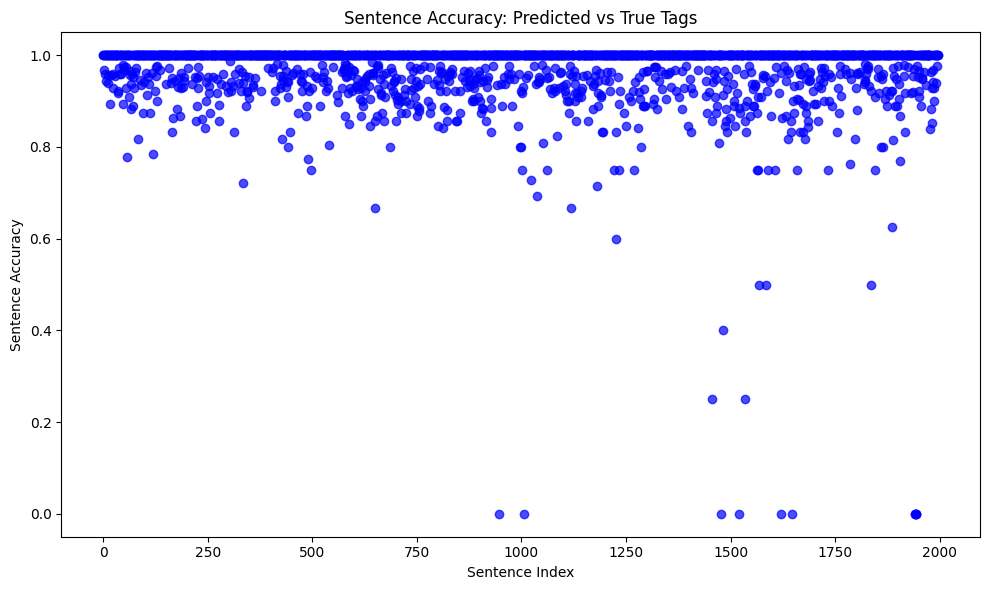

In [81]:
# Carregar os resultados do CSV
df = pd.read_csv("./resultados_analise.csv")

# Plotar acurácia das sentenças
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['Accuracy'], color='blue', alpha=0.7)
plt.xlabel('Sentence Index')
plt.ylabel('Sentence Accuracy')
plt.title('Sentence Accuracy: Predicted vs True Tags')
plt.tight_layout()
plt.show()

In [82]:
# Carregar os resultados do CSV usando pandas
df = pd.read_csv('./resultados_analise_completa.csv')

# Certifique-se de que as colunas estão corretamente convertidas para o tipo numérico
df['Sentence Accuracy'] = pd.to_numeric(df['Sentence Accuracy'], errors='coerce')
df['Word Accuracy'] = pd.to_numeric(df['Word Accuracy'], errors='coerce')

df.head()

,Sentence,Word,Predicted Tags,True Tags,Sentence Accuracy,Word Accuracy
0,"Ainda em dezembro de 1990, foi editada a famos...",Ainda,ADV,ADV,1.0,1
1,"Ainda em dezembro de 1990, foi editada a famos...",em,PREP,PREP,1.0,1
2,"Ainda em dezembro de 1990, foi editada a famos...",dezembro,N,N,1.0,1
3,"Ainda em dezembro de 1990, foi editada a famos...",de,PREP,PREP,1.0,1
4,"Ainda em dezembro de 1990, foi editada a famos...","1990,",N,N,1.0,1


In [83]:
#remover a coluna Sentence
df2 = df.drop(columns=['Sentence'])
df2.head()

,Word,Predicted Tags,True Tags,Sentence Accuracy,Word Accuracy
0,Ainda,ADV,ADV,1.0,1
1,em,PREP,PREP,1.0,1
2,dezembro,N,N,1.0,1
3,de,PREP,PREP,1.0,1
4,"1990,",N,N,1.0,1


C:\Users\thais\AppData\Local\Temp\ipykernel_11888\4162474628.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Word Accuracy', y='True Tags', data=tag_accuracy, palette='viridis')


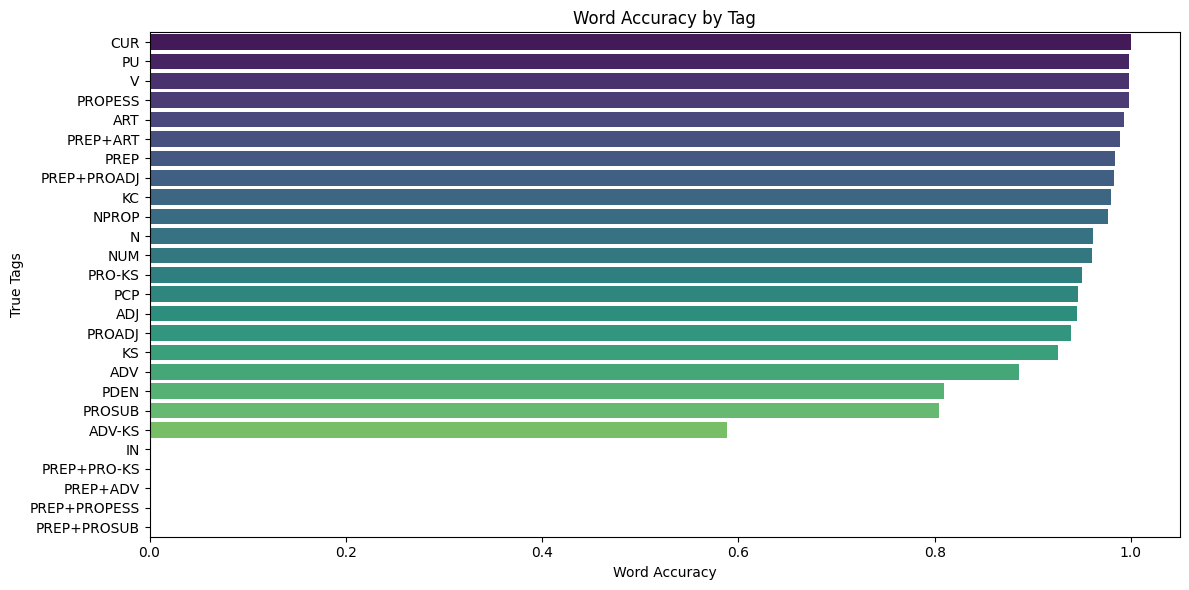

In [84]:
#analisar a quantidade de acertos por Tags
tag_accuracy = df2.groupby('True Tags')['Word Accuracy'].mean().reset_index()
tag_accuracy = tag_accuracy.sort_values(by='Word Accuracy', ascending=False)

# Plotar a acurácia por tags
plt.figure(figsize=(12, 6))
sns.barplot(x='Word Accuracy', y='True Tags', data=tag_accuracy, palette='viridis')
plt.xlabel('Word Accuracy')
plt.ylabel('True Tags')
plt.title('Word Accuracy by Tag')
plt.tight_layout()
plt.show()


C:\Users\thais\AppData\Local\Temp\ipykernel_11888\976565632.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='True Tags', data=tag_count, palette='viridis')


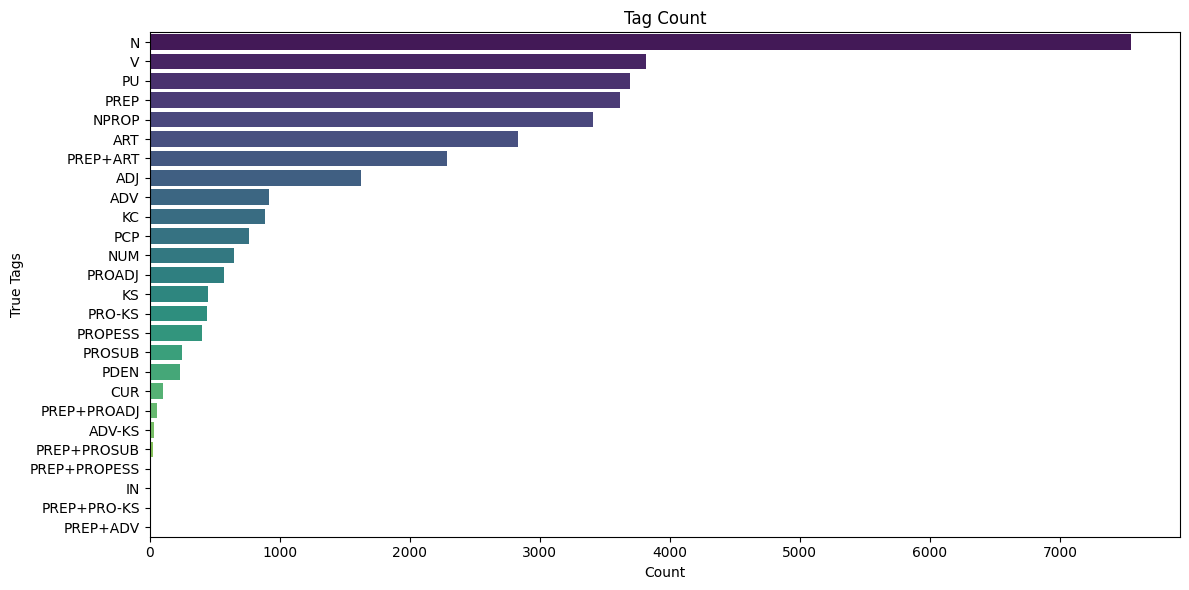

In [85]:
#quantas vezes cada tag aparece em True Tags
tag_count = df['True Tags'].value_counts().reset_index()
tag_count.columns = ['True Tags', 'Count']
tag_count = tag_count.sort_values(by='Count', ascending=False)

# Plotar a contagem de tags
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='True Tags', data=tag_count, palette='viridis')
plt.xlabel('Count')
plt.ylabel('True Tags')
plt.title('Tag Count')
plt.tight_layout()
plt.show()

